# Atividade 8 - Classificador MLP
# Relief - Sem Normalização
# Algoritmo MLPClassifier

● Seguir o mesmo padrão das atividades 6 e 7, mas agora para redes MLP

● Realizar validação cruzada para testar redes neurais (mesmos subconjuntos utilizados em SVMs)
utilizando:

    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)
    
Em cada um, calibrar os parâmetros (número de neurônios da camada oculta (ex: 10, raiz quadrada
do nr de características, um nr maior), taxa de aprendizado (ex: 0,1; 0,01), função de ativação
(sigmoide na camada de saída, mas na camada oculta testar tangente hiperbólica e leaky relu (ou
relu)) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou
melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math


from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing


# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.neural_network import MLPClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo Relief na atividade 4

In [3]:
selecionadas_Relief = ['Age',
                       'Num of pregnancies',
                       'Hormonal Contraceptives (years)',
                       'First sexual intercourse',
                       'STDs (number)',
                       'STDs: Number of diagnosis',
                       'Hinselmann',
                       'Schiller',
                       'Citology', 
                       'STDs']

## Pré-Processamento

In [4]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [5]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:

    Para features categoricas --> preenche com o valor mais frequente

No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)


In [6]:
continuous_feat = [ 'Age',
                    'Num of pregnancies',
                    'Hormonal Contraceptives (years)',
                    'First sexual intercourse',
                    'STDs (number)',
                    'STDs: Number of diagnosis'] 

binary_feat = ['Hinselmann',
               'Schiller',
               'Citology', 
               'STDs']

In [7]:
df_imp = df_processed.copy()

In [8]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()

## Stratified Cross- Validation

### Dataset Desbalanceado

In [9]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    n_Neurons_range = grid_params.get('n_Neurons_range')
    n_layers_range = grid_params.get('n_layers_range')
    learning_rate_init_range = grid_params.get('learning_rate_init_range')
    f_Activation = grid_params.get('f_Activation')
    momentum_range = grid_params.get('momentum_range')
    max_iter = grid_params.get('max_iter')
    early_stopping = grid_params.get('early_stopping')       
    
    # Testa varias funções de ativação
    for func in f_Activation:
        print("-> Teste função {}".format(func))
        
        # Testa para 1 a n layers
        for layers in list(np.arange(n_layers_range[0], n_layers_range[1]+1, 1)):
            
            # Calcula o numero de possiveis configuracoes de MLP (n de layers e neuronios por layers)
            n_possibilidades = pow(len(n_Neurons_range),layers)

            # Monta uma tuple com a configuracao atual
            for i in range (n_possibilidades):
                config = tuple()
                encoded = i
                for j in range (layers):
                    new_neuron = math.floor(encoded / pow(len(n_Neurons_range),(layers - j - 1)))

                    config = config + (n_Neurons_range[new_neuron], )
                    encoded = encoded % math.pow(len(n_Neurons_range),(layers - j - 1))

                # Testa varios learning_rate
                for learning_rate_i in learning_rate_init_range:

                    # Testa vários momentums para o sgd
                    for momentum in momentum_range:
                    
                        # Testa vários valores maximos de iteracao
                        for iters in max_iter:
                        
                            # Testa com e sem early stop
                            for stop in early_stopping:
                                
                                print('-> Modelo: func ={} | params {} | learning_rate={:.3f} | momentum = {:.2f} | max_iter = {} | early_stopping = {}'.format(
                                    func, config, learning_rate_i, momentum,iters, stop))
                                clf = algoritmo(activation=func, hidden_layer_sizes=config, learning_rate_init=learning_rate_i, 
                                                solver = 'sgd', momentum = momentum,max_iter = iters,early_stopping = stop,
                                                verbose=0, random_state = random_state)

                                # Folds
                                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                                    fold_number = fold
                                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                                    # quantidade de classes dentro da fold
                                    #REMOVED

                                    # aplica o classificador
                                    clf = clf.fit(X_train, y_train)

                                    # predict no dataset de treino 
                                    y_train_preds = clf.predict(X_train)
                                    # predict no dataset de teste
                                    y_pred = clf.predict(X_test)


                                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                                    recall = recall_score(y_test, y_pred)
                                    accuracy = accuracy_score(y_test, y_pred)
                                    precision = precision_score(y_test, y_pred)
                                    scores.append([config, learning_rate_i, func, momentum, iters, stop,
                                                   clf.n_iter_, fold_number, precision, recall, accuracy])



    return np.array(scores)

### Dataset Balanceado

In [10]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    n_Neurons_range = grid_params.get('n_Neurons_range')
    n_layers_range = grid_params.get('n_layers_range')
    learning_rate_init_range = grid_params.get('learning_rate_init_range')
    f_Activation = grid_params.get('f_Activation')
    momentum_range = grid_params.get('momentum_range')
    max_iter = grid_params.get('max_iter')
    early_stopping = grid_params.get('early_stopping')   
    
    
    # Testa varias funções de ativação
    for func in f_Activation:
        print("-> Teste função {}".format(func))
        
        # Testa para 1 a n layers
        for layers in list(np.arange(n_layers_range[0], n_layers_range[1]+1, 1)):
            
            # Calcula o numero de possiveis configuracoes de MLP (n de layers e neuronios por layers)
            n_possibilidades = pow(len(n_Neurons_range),layers)

            # Monta uma tuple com a configuracao atual
            for i in range (n_possibilidades):
                config = tuple()
                encoded = i
                for j in range (layers):
                    new_neuron = math.floor(encoded / pow(len(n_Neurons_range),(layers - j - 1)))

                    config = config + (n_Neurons_range[new_neuron], )
                    encoded = encoded % math.pow(len(n_Neurons_range),(layers - j - 1))
                    
                # Testa varios learning_rate
                for learning_rate_i in learning_rate_init_range:

                    # Testa vários momentums para o sgd
                    for momentum in momentum_range:
                    
                        # Testa vários valores maximos de iteracao
                        for iters in max_iter:
                        
                            # Testa com e sem early stop
                            for stop in early_stopping:
                                
                                print('-> Modelo: func ={} | params {} | learning_rate={:.3f} | momentum = {:.2f} | max_iter = {} | early_stopping = {}'.format(
                                    func, config, learning_rate_i, momentum,iters, stop))
                                clf = algoritmo(activation=func, hidden_layer_sizes=config, learning_rate_init=learning_rate_i, 
                                                solver = 'sgd', momentum = momentum,max_iter = iters,early_stopping = stop,
                                                verbose=0, random_state = random_state)

                                # Folds
                                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                                    fold_number = fold
                                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                                    # Normaliza MinMax para aplicar Smote
                                    X_train_normalized = minmax_scale.fit_transform(X_train)
                                    X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                                    # SMOTETomek (apenas os dados de treino)
                #                    print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                                    X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                                    # Retorna para valores não normalizados
                                    X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                #                    print folds balanceados
                                    #REMOVED

                                    # quantidade de classes dentro da fold
                                    #REMOVED

                                    # aplica o classificador
                                    clf = clf.fit(X_train, y_train)

                                    # predict no dataset de treino 
                                    y_train_preds = clf.predict(X_train)
                                    # predict no dataset de teste
                                    y_pred = clf.predict(X_test)


                                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                                    recall = recall_score(y_test, y_pred)
                                    accuracy = accuracy_score(y_test, y_pred)
                                    precision = precision_score(y_test, y_pred)
                                    scores.append([config, learning_rate_i, func, momentum, iters, stop,
                                                   clf.n_iter_, fold_number, precision, recall, accuracy])


    return np.array(scores)

## Grid de Parametros para teste

In [11]:
grid_params_all = {'n_Neurons_range': [5,7,10,15,20],
                   'n_layers_range' : [1,2],
               'learning_rate_init_range': [0.001, 0.01, 0.1],
               'f_Activation': ['logistic', 'tanh', 'relu'],
                'momentum_range': [0.3, 0.6,  0.9],
                'max_iter':[300],
                'early_stopping':[True,False]
              }


#tol/n_iter_no_change




## Calculando Precisão, Revocação e Acurácia

### Algortimo-> MLPClassifier

In [12]:
df_selecionado = df_imp[selecionadas_Relief]
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

df_selecionado.head()

,Age,Num of pregnancies,Hormonal Contraceptives (years),First sexual intercourse,STDs (number),STDs: Number of diagnosis,Hinselmann,Schiller,Citology,STDs,Biopsy
0,18.0,1.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,15.0,1.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,34.0,1.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,52.0,4.0,3.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,46.0,4.0,15.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Dataset Desbalanceado

In [13]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Configuration', 1: 'learning_rate_init', 2: 'f_Activation',
                                                        3:'Momentum', 4:'Max_iters', 5:'Early_stop', 6:'n_iters',
                                                        7:'Fold', 8: 'Precision', 9: 'Recall', 10: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'MLPClassifier'
float_cols = ['learning_rate_init', 'Momentum', 'Max_iters', 'n_iters', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste função logistic
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.010

In [14]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Relief-Sem_Normalizacao_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,n_iters,Fold,Precision,Recall,Accuracy,Algorimto
0,"(5,)",0.001,logistic,0.3,300,True,12,1,0.058140,1.0,0.058140,MLPClassifier
1,"(5,)",0.001,logistic,0.3,300,True,12,2,0.058140,1.0,0.058140,MLPClassifier
2,"(5,)",0.001,logistic,0.3,300,True,12,3,0.058140,1.0,0.058140,MLPClassifier
3,"(5,)",0.001,logistic,0.3,300,True,12,4,0.069767,1.0,0.069767,MLPClassifier
4,"(5,)",0.001,logistic,0.3,300,True,12,5,0.069767,1.0,0.069767,MLPClassifier


### Dataset Balanceado

In [15]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_balanced = scores_balanced.rename(columns = {0: 'Configuration', 1: 'learning_rate_init', 2: 'f_Activation',
                                                        3:'Momentum', 4:'Max_iters', 5:'Early_stop', 6:'n_iters',
                                                        7:'Fold', 8: 'Precision', 9: 'Recall', 10: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'MLPClassifier'
float_cols = ['learning_rate_init', 'Momentum', 'Max_iters', 'n_iters', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste função logistic
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | lea

In [16]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Relief-Sem_Normalizacao_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,n_iters,Fold,Precision,Recall,Accuracy,Algorimto
0,"(5,)",0.001,logistic,0.3,300,True,12,1,0.058140,1.0,0.058140,MLPClassifier
1,"(5,)",0.001,logistic,0.3,300,True,12,2,0.058140,1.0,0.058140,MLPClassifier
2,"(5,)",0.001,logistic,0.3,300,True,12,3,0.058140,1.0,0.058140,MLPClassifier
3,"(5,)",0.001,logistic,0.3,300,True,12,4,0.069767,1.0,0.069767,MLPClassifier
4,"(5,)",0.001,logistic,0.3,300,True,12,5,0.069767,1.0,0.069767,MLPClassifier


## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [17]:
mean_unbalanced = scores_unbalanced.groupby(['Configuration', 'learning_rate_init', 'f_Activation',
                                             'Momentum', 'Max_iters', 'Early_stop']).mean().drop('Fold', axis = 1)
mean_unbalanced

n_iters  Precision    Recall  Accuracy
Configuration learning_rate_init f_Activation Momentum Max_iters Early_stop                                        
(5,)          0.001              logistic     0.3      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           12.0   0.064090  1.000000  0.064090
                                              0.6      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           23.0   0.000000  0.000000  0.935910
                                              0.9      300       False         147.2   0.000000  0.000000  0.935910
                                                                 True           16.0   0.000000  0.000000  0.935910
                                 relu         0.3      300       False         243.7   0.100000  0.020000  0.937073
                                                                 True           12.9   0.100000  0.020000  0.928933
                                              0.6      300       False         287.4   0.100000  0.020000  0.937073
                                                                 True           12.0   0.100000  0.020000  0.934747
                                              0.9      300       False         300.0   0.300000  0.090000  0.938222
                                                                 True           12.0   0.000000  0.000000  0.935910
                                 tanh         0.3      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           12.0   0.000000  0.000000  0.935910
                                              0.6      300       False         262.2   0.000000  0.000000  0.935910
                                                                 True           12.0   0.000000  0.000000  0.935910
                                              0.9      300       False         110.5   0.000000  0.000000  0.935910
                                                                 True           12.0   0.000000  0.000000  0.935910
              0.010              logistic     0.3      300       False         117.6   0.000000  0.000000  0.935910
                                                                 True           13.0   0.000000  0.000000  0.934747
                                              0.6      300       False          81.6   0.000000  0.000000  0.935910
                                                                 True           13.0   0.000000  0.000000  0.935910
                                              0.9      300       False          26.0   0.000000  0.000000  0.935910
                                                                 True           12.0   0.000000  0.000000  0.935910
                                 relu         0.3      300       False          95.8   0.333333  0.076667  0.938235
                                                                 True           12.0   0.000000  0.000000  0.935910
                                              0.6      300       False         262.4   0.593333  0.203333  0.941737
                                                                 True           12.0   0.000000  0.000000  0.935910
                                              0.9      300       False         164.6   0.662778  0.396667  0.945226
                                                                 True           12.0   0.000000  0.000000  0.935910
                                 tanh         0.3      300       False          86.5   0.000000  0.000000  0.935910
                                                                 True           12.0   0.000000  0.000000  0.935910
                                              0.6      300       False          61.7   0.000000  0.000000  0.935910
                 

In [18]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

,,,,,,n_iters,Precision,Recall,Accuracy
Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,,,,
"(10, 7)",0.01,relu,0.6,300,False,297.6,0.556667,0.326667,0.952216
"(15,)",0.01,relu,0.9,300,False,194.2,0.653810,0.503333,0.949904
"(20,)",0.01,relu,0.9,300,False,159.7,0.638690,0.440000,0.948741
"(10, 5)",0.01,relu,0.6,300,False,273.7,0.526667,0.473333,0.948687
"(5, 20)",0.01,relu,0.9,300,False,186.6,0.290000,0.260000,0.947538


((10, 7), 0.01, 'relu', 0.6, 300, False)

### Dataset Balanceado

In [19]:
mean_balanced = scores_balanced.groupby(['Configuration', 'learning_rate_init', 'f_Activation', 
                                         'Momentum', 'Max_iters','Early_stop']).mean().drop('Fold', axis = 1)
mean_balanced

n_iters  Precision    Recall  Accuracy
Configuration learning_rate_init f_Activation Momentum Max_iters Early_stop                                        
(5,)          0.001              logistic     0.3      300       False          17.9   0.064090  1.000000  0.064090
                                                                 True           12.0   0.064090  1.000000  0.064090
                                              0.6      300       False          31.1   0.064090  1.000000  0.064090
                                                                 True           12.0   0.064090  1.000000  0.064090
                                              0.9      300       False          27.0   0.064172  1.000000  0.065253
                                                                 True           12.0   0.064090  1.000000  0.064090
                                 relu         0.3      300       False         300.0   0.678056  0.783333  0.958044
                                                                 True           59.0   0.312300  0.650000  0.847059
                                              0.6      300       False         300.0   0.661389  0.823333  0.958057
                                                                 True           71.6   0.362564  0.673333  0.869152
                                              0.9      300       False         212.6   0.673034  0.860000  0.959207
                                                                 True           58.3   0.525763  0.836667  0.932394
                                 tanh         0.3      300       False          61.8   0.000000  0.000000  0.935910
                                                                 True           12.0   0.000000  0.000000  0.935910
                                              0.6      300       False          48.9   0.000000  0.000000  0.935910
                                                                 True           12.0   0.000000  0.000000  0.935910
                                              0.9      300       False          24.9   0.000000  0.000000  0.935910
                                                                 True           12.0   0.000000  0.000000  0.935910
              0.010              logistic     0.3      300       False          24.8   0.063925  0.983333  0.076895
                                                                 True           12.0   0.064090  1.000000  0.064090
                                              0.6      300       False          20.4   0.066715  0.696667  0.294350
                                                                 True           14.9   0.058276  0.900000  0.150137
                                              0.9      300       False          58.4   0.253452  0.323333  0.825321
                                                                 True           24.7   0.167891  0.593333  0.580369
                                 relu         0.3      300       False          66.6   0.305820  0.743333  0.446566
                                                                 True           53.9   0.373010  0.780000  0.877456
                                              0.6      300       False          84.6   0.483379  0.780000  0.787592
                                                                 True           44.8   0.481705  0.760000  0.916060
                                              0.9      300       False          40.0   0.226479  0.876667  0.346717
                                                                 True           29.4   0.387130  0.766667  0.862476
                                 tanh         0.3      300       False          21.8   0.024722  0.400000  0.587346
                                                                 True           12.0   0.000000  0.000000  0.935910
                                              0.6      300       False          18.7   0.044405  0.700000  0.325718
                 

In [20]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

n_iters  Precision    Recall  Accuracy
Configuration learning_rate_init f_Activation Momentum Max_iters Early_stop                                        
(10, 7)       0.001              relu         0.9      300       False         212.6   0.679365  0.876667  0.961546
(7,)          0.001              relu         0.9      300       False         288.6   0.683135  0.876667  0.961546
(10, 5)       0.001              tanh         0.9      300       False         300.0   0.687579  0.843333  0.961546
(20,)         0.010              logistic     0.6      300       False         300.0   0.671230  0.826667  0.960397
              0.001              relu         0.9      300       False         227.5   0.674206  0.860000  0.960383

((7,), 0.001, 'relu', 0.9, 300, False)

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [21]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['Configuration'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['learning_rate_init'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['f_Activation'] == max_alpha_unbalanced[2]) &
                                                             (scores_unbalanced['Momentum'] == max_alpha_unbalanced[3]) &
                                                             (scores_unbalanced['Max_iters'] == max_alpha_unbalanced[4]) &
                                                             (scores_unbalanced['Early_stop'] == max_alpha_unbalanced[5])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.952, IC = [0.942, 0.962]
Recall: Média = 0.327, IC = [0.137, 0.516]
Precisão: Média = 0.557, IC = [0.255, 0.858]


### Dataset Balanceado

In [22]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['Configuration'] == max_alpha_balanced[0]) &
                                                             (scores_balanced['learning_rate_init'] == max_alpha_balanced[1]) &
                                                             (scores_balanced['f_Activation'] == max_alpha_balanced[2]) &
                                                             (scores_balanced['Momentum'] == max_alpha_balanced[3]) &
                                                             (scores_balanced['Max_iters'] == max_alpha_balanced[4]) &
                                                             (scores_balanced['Early_stop'] == max_alpha_balanced[5])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.962, IC = [0.946, 0.977]
Recall: Média = 0.877, IC = [0.793, 0.960]
Precisão: Média = 0.683, IC = [0.554, 0.812]


## Gráfico

In [23]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

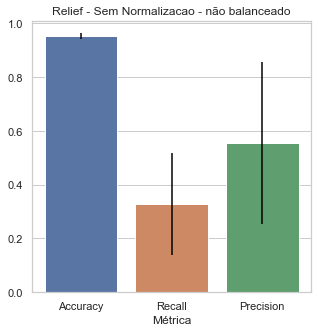

In [24]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Relief - Sem Normalizacao - não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Relief-Sem_Normalizacao-nao_balanceado-MLPClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

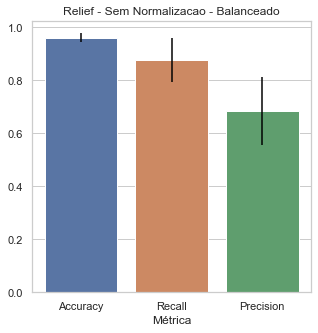

In [25]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Relief - Sem Normalizacao - Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Relief-Sem_Normalizacao-balanceado-MLPClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [26]:
path_to_save = '../../model_results/'
score_min_unbalanced = pd.DataFrame([acc_min_unbalanced, rec_min_unbalanced, pre_min_unbalanced]).rename(columns = {0: 'Score'})
score_max_unbalanced =  pd.DataFrame([acc_max_unbalanced, rec_max_unbalanced, pre_max_unbalanced]).rename(columns = {0: 'Score'})
score_min_balanced = pd.DataFrame([acc_min_balanced, rec_min_balanced, pre_min_balanced]).rename(columns = {0: 'Score'})
score_max_balanced =  pd.DataFrame([acc_max_balanced, rec_max_balanced, pre_max_balanced]).rename(columns = {0: 'Score'})

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    'MLPClassifier',
    '8',
    'ReliefF Desbalanceado - Nao Normalizado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    'MLPClassifier',
    '8',
    'ReliefF Balanceado - Nao Normalizado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_balanced[metrica],score_min_balanced.loc[metrica]['Score'], score_max_balanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Algoritmo,Atividade,Condicao,Melhores_Params,Metrica,Valor,Intervalo_Confianca
0,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Accuracy,0.896129,"[0.896, 0.857, 0.935]"
1,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Recall,0.02,"[0.020, -0.025, 0.065]"
2,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Precision,0.00666667,"[0.007, -0.008, 0.022]"
3,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Accuracy,0.690109,"[0.690, 0.473, 0.907]"
4,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Recall,0.216667,"[0.217, -0.049, 0.482]"
5,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Precision,0.0492712,"[0.049, -0.024, 0.123]"
6,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Accuracy,0.822886,"[0.823, 0.784, 0.862]"
7,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Recall,0.153333,"[0.153, 0.034, 0.272]"
8,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Precision,0.0906421,"[0.091, 0.013, 0.169]"
9,Naive Bayes,6,Branch and Bound Balanceado - Normalizado,0.1,Accuracy,0.512845,"[0.513, 0.416, 0.610]"


Resultados salvos com sucesso
